In [1]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [2]:
import numpy as np
import modisco

flanksize=20

onehot_data = np.load('extracted_onehot.npy')[:,:]
hypothetical_data = np.load('extracted_hypothetical_scores.npy')[:,:]
contrib_data = np.load('extracted_contrib_scores.npy')[:,:]

contrib_scores_track = modisco.core.DataTrack(name="contrib_scores",
                                 fwd_tracks=contrib_data,
                                 rev_tracks=contrib_data[:,::-1, ::-1])
hypcontrib_scores_track = modisco.core.DataTrack(name="hypcontrib_scores",
                                    fwd_tracks=hypothetical_data,
                                    rev_tracks=hypothetical_data[:,::-1, ::-1])
onehot_track = modisco.core.DataTrack(name="onehot",
                         fwd_tracks=onehot_data,
                         rev_tracks=onehot_data[:,::-1, ::-1])
track_set = modisco.core.DataTrackSet(data_tracks=[
                contrib_scores_track, hypcontrib_scores_track, onehot_track])

coords = []
perposimp = np.sum(contrib_data,axis=-1)[:,50:50+41]
for example_idx in range(len(onehot_data)):
    #figure out the 6bp window with highest imp
    padded_cumsum = np.array([0]+list(np.cumsum(perposimp[example_idx])))
    sliding_window_imp = padded_cumsum[7:] - padded_cumsum[:-7]
    start = np.argmax(sliding_window_imp)+50
    coords.append(modisco.core.Coordinate(
                    example_idx=example_idx, start=start-17,
                    end=start+24, is_revcomp=False))

all_seqlets = [x for x in track_set.create_seqlets(coords=coords, flanks=flanksize) if np.sum(x["contrib_scores"].corefwd) > 0]

/Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


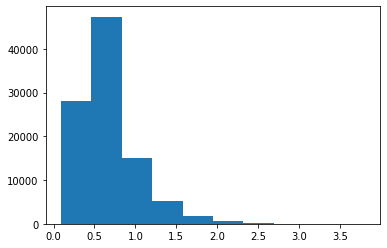

In [3]:
from matplotlib import pyplot as plt
plt.hist([np.sum(x["contrib_scores"].corefwd) for x in all_seqlets])
plt.show()

In [4]:
seqlets_subsample = [all_seqlets[i] for i in np.random.RandomState(1).choice(
                                              np.arange(len(all_seqlets)), size=5000,replace=False)]

In [5]:
len(seqlets_subsample)

5000

In [12]:
import modisco.affinitymat
reload(modisco.affinitymat)
import modisco.util
reload(modisco.util)
import gc
gc.collect()

min_overlap_frac=0.75

affmat_computer = modisco.affinitymat.SequenceAffmatComputer_Impute(
                    metric=modisco.util.l1norm_contin_jaccard_sim,
                    n_jobs=8, min_overlap_frac=min_overlap_frac)

affmat, offsets, isfwdmat = affmat_computer(seqlets_subsample, onehot_trackname="onehot",
                                            hyp_trackname="hypcontrib_scores")

np.save("affmat_recenter_41bpseqlets_"+str(min_overlap_frac)+".npy", affmat)
np.save("offsets_recenter_41bpseqlets_"+str(min_overlap_frac)+".npy", offsets)
np.save("isfwdmat_recenter_41bpseqlets_"+str(min_overlap_frac)+".npy", isfwdmat)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   10.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   34.8s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  2.4min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:  4.0min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:  5.7min
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:  7.7min
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:  9.9min
[Parallel(n_jobs=8)]: Done 4034 tasks      | elapsed: 12.4min
[Parallel(n_jobs=8)]: Done 4984 tasks      | elapsed: 15.1min
[Parallel(n_jobs=8)]: Done 5000 out of 5000 | elapsed: 15.1min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.7s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   31.4s
[Parallel(n_jobs=8)]: Done 434 tasks    

In [13]:
!ls

TestNewModiscoBPNet.ipynb              isfwdmat_0.6.npy
affmat_0.6.npy                         isfwdmat_recenter_0.35.npy
affmat_recenter_0.35.npy               isfwdmat_recenter_41bpseqlets_0.75.npy
affmat_recenter_41bpseqlets_0.75.npy   offsets_0.6.npy
extracted_contrib_scores.npy           offsets_recenter_0.35.npy
extracted_hypothetical_scores.npy      offsets_recenter_41bpseqlets_0.75.npy
extracted_onehot.npy


In [40]:
affmat = np.load("affmat_recenter_41bpseqlets_0.75.npy")
offsets = np.load("offsets_recenter_41bpseqlets_0.75.npy")
isfwdmat = np.load("isfwdmat_recenter_41bpseqlets_0.75.npy")

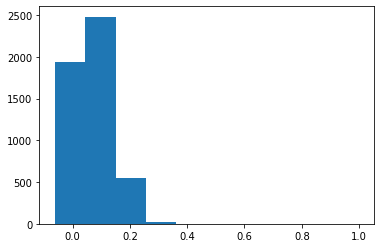

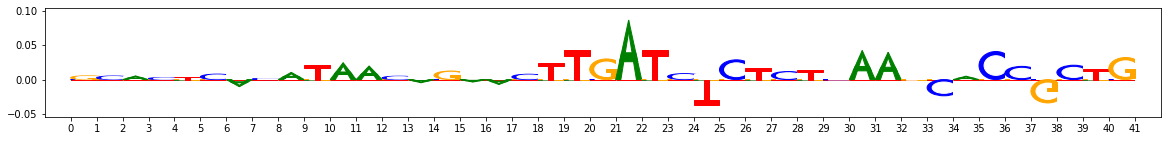

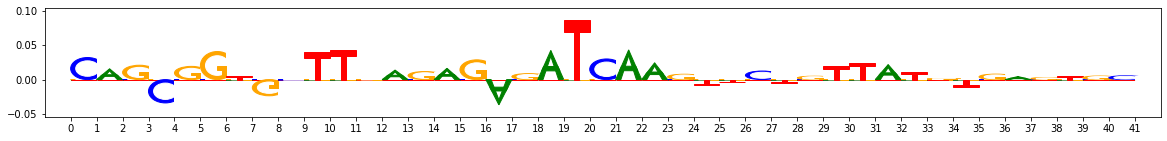

In [41]:
from modisco.visualization import viz_sequence

idx=4
plt.hist(affmat[idx])
viz_sequence.plot_weights(seqlets_subsample[idx]["contrib_scores"].corefwd)
viz_sequence.plot_weights(seqlets_subsample[idx]["contrib_scores"].corerev)
plt.show()

In [17]:
import modisco.core
reload(modisco.core)
import modisco.affinitymat
reload(modisco.affinitymat)

flatten = 1
distmat = np.log(1.0/(flatten*np.maximum(affmat,1e-7)) - (1.0/flatten - 1))

import umap
import leidenalg
n_neighbors = 10
tsne_adapted = modisco.affinitymat.tsne_density_adaptation(dist_mat=distmat,
                                                           perplexity=n_neighbors)

[t-SNE] Computing 4999 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.042s...
[t-SNE] Computed neighbors for 5000 samples in 2.826s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.229123


Median number of neighbors - tsne 36.0


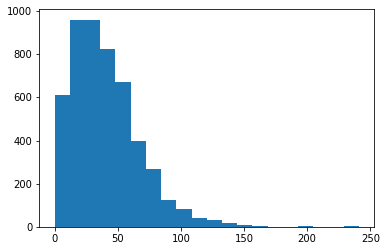

In [18]:
print("Median number of neighbors - tsne",np.median(np.sum(tsne_adapted>0, axis=1)))
plt.hist(np.sum(tsne_adapted>0, axis=1), bins=20)
plt.show()

In [ ]:
from collections import Counter
reload(modisco.affinitymat)
from modisco.affinitymat import nearest_neighb_affmat
from modisco.affinitymat import get_diffusion_distances
import sklearn.cluster

nneighb_affmat = nearest_neighb_affmat(affmat=affmat, n_neighbs=[5, 10, 15, 20, 25, 30])
dmap = np.real(modisco.affinitymat.get_concat_dmap_coords(affmat=nneighb_affmat, ts=[1],
                                                          k=int(len(nneighb_affmat)/50)))
distmat = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(dmap, metric='euclidean'))

In [74]:
"""kmeans_clustdist = sklearn.cluster.KMeans(n_clusters=int(len(nneighb_affmat)/100),
                                          n_init=100, random_state=1234).fit_transform(dmap)
the_clustering = np.argmin(kmeans_clustdist,axis=-1)"""

#get Leiden averaged over different seeds
averaging_rounds = 0
#current_affmat = np.linalg.matrix_power(tsne_adapted, 1)
current_affmat = 1.0/np.exp(distmat)
#keep top 10% for speed
current_affmat = current_affmat > np.percentile(current_affmat.ravel(), q=90)
for round_num in range(averaging_rounds):
    current_affmat = modisco.affinitymat.average_over_different_seeds(
                        affmat=current_affmat,
                        clustering_procedure=modisco.affinitymat.LeidenClustering(
                                                partitiontype=leidenalg.ModularityVertexPartition,
                                                n_iterations=1),
                        nseeds=200)

the_clustering = modisco.affinitymat.take_best_over_different_seeds(affmat=current_affmat,
                                                clustering_procedure=modisco.affinitymat.LeidenClustering(
                                                    partitiontype=leidenalg.ModularityVertexPartition,
                                                    n_iterations=-1),
                                                nseeds=10)
print(Counter(the_clustering))

Quality: 0.12039492391807993
Quality: 0.12050078681151995
Quality: 0.12052655989407997

Counter({0: 1430, 1: 993, 2: 785, 3: 646, 4: 278, 5: 212, 6: 174, 7: 94, 8: 53, 9: 31, 10: 24, 11: 19, 12: 19, 13: 19, 14: 18, 15: 17, 16: 13, 17: 12, 18: 10, 21: 9, 20: 9, 19: 9, 22: 6, 23: 6, 24: 5, 25: 5, 27: 5, 26: 5, 28: 4, 29: 3, 30: 3, 31: 2, 32: 2, 33: 2, 34: 2, 38: 2, 35: 2, 36: 2, 37: 2, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 91: 1, 92: 1, 93: 1, 94: 1, 95: 1, 96: 1, 97: 1, 98: 1, 99: 1, 100: 1, 101: 1, 102: 1, 103: 1, 104: 1, 105: 1, 106: 1})


Numbed of clusters: 107
Cluster idx 0 size 1430


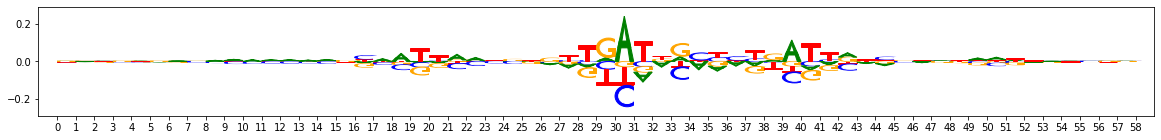

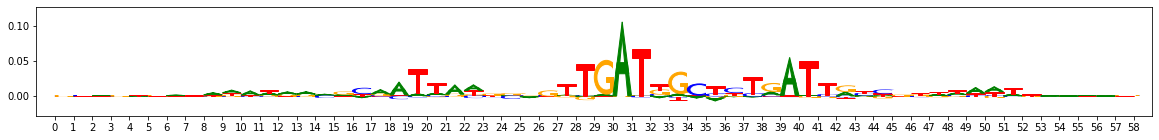

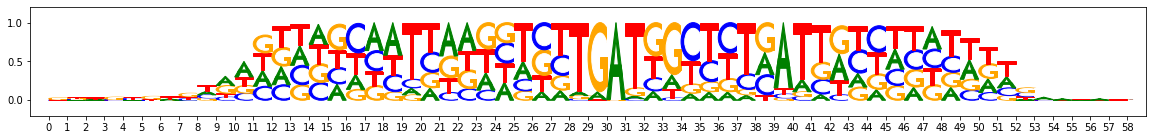

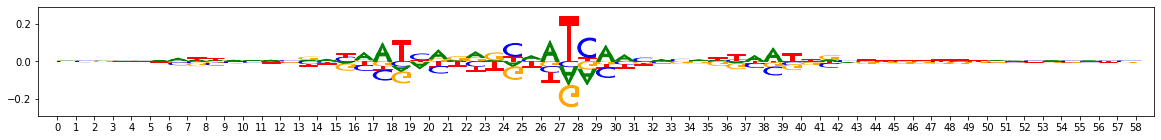

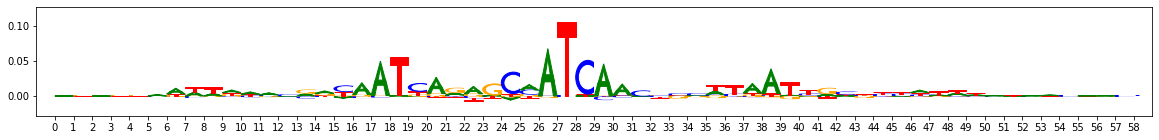

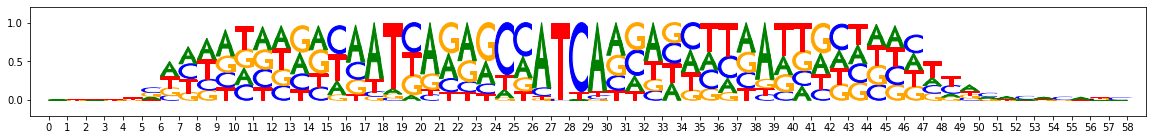

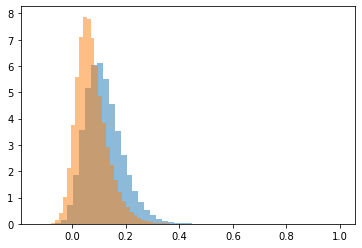

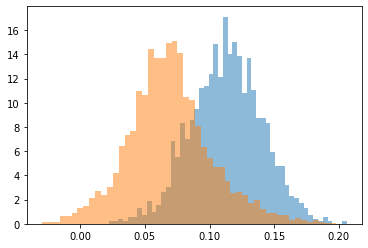

Cluster idx 1 size 993


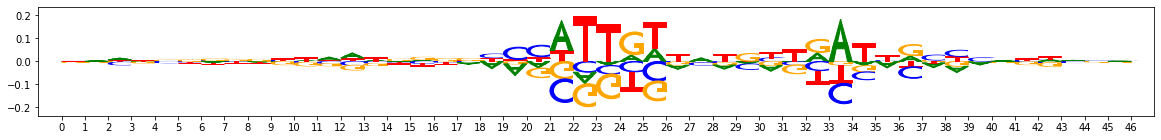

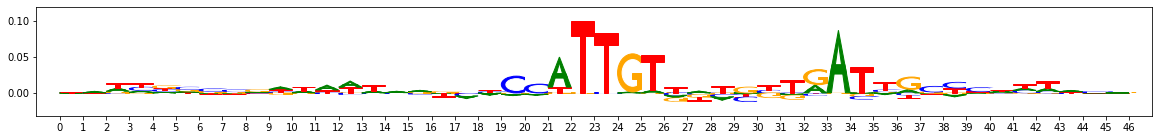

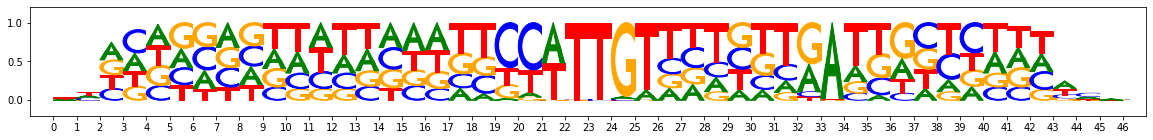

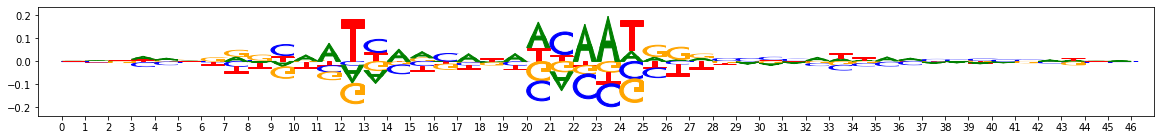

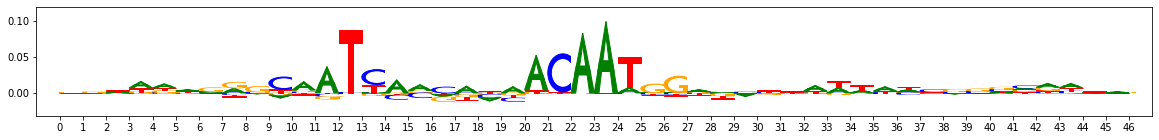

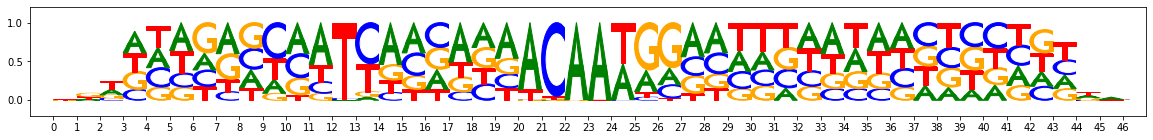

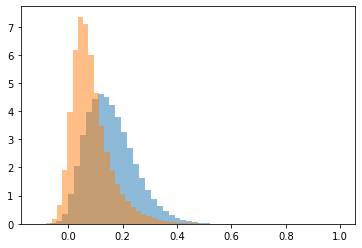

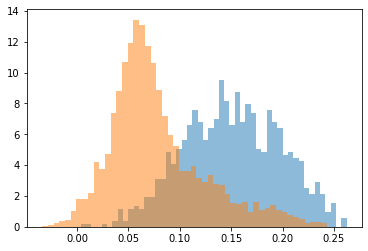

Cluster idx 2 size 785


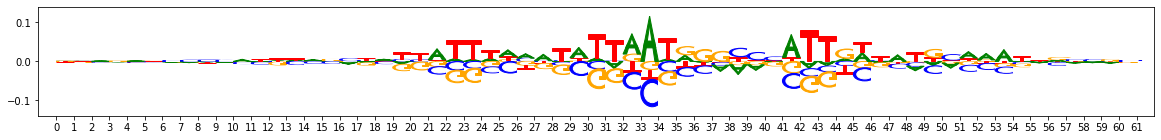

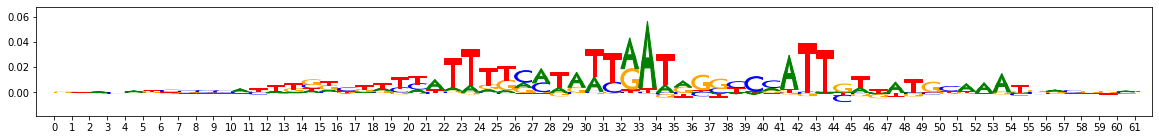

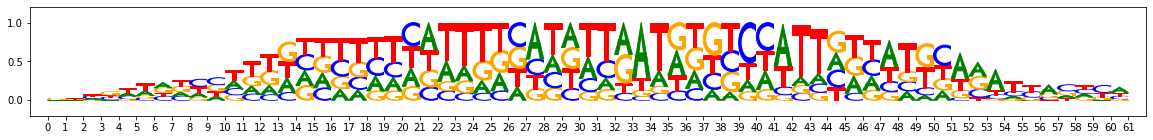

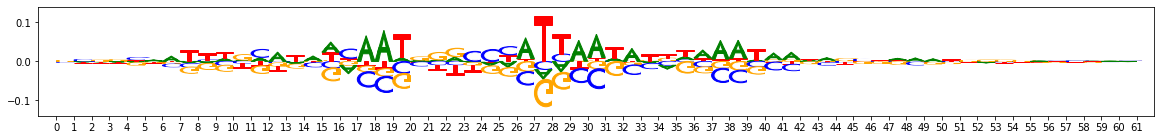

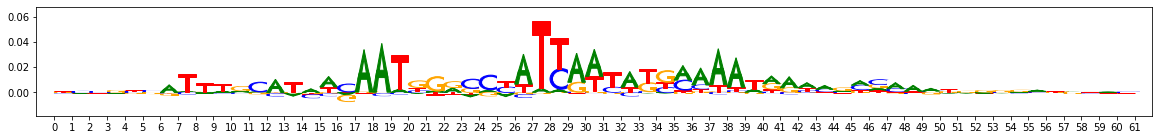

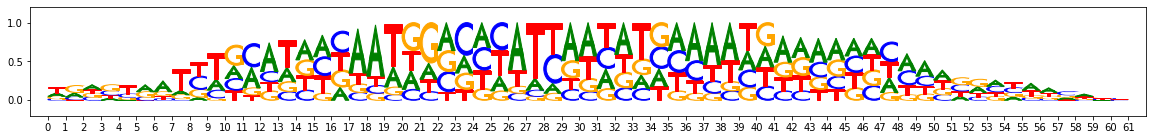

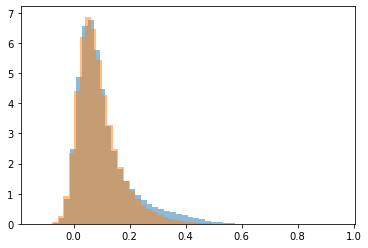

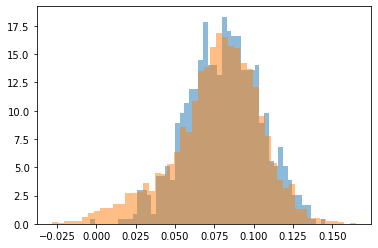

Cluster idx 3 size 646


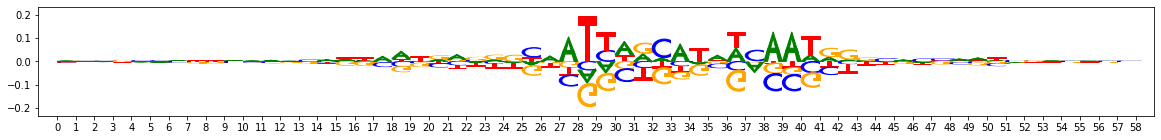

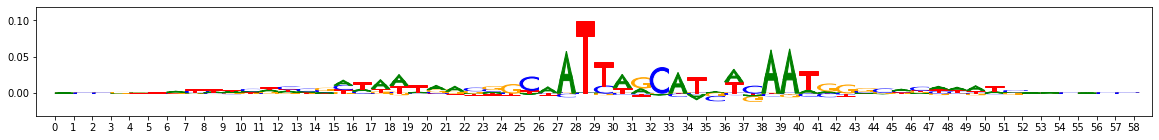

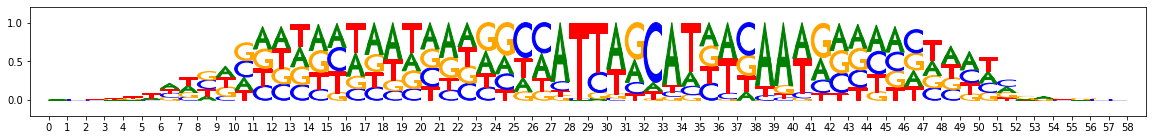

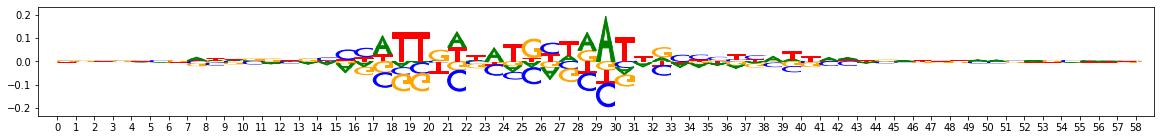

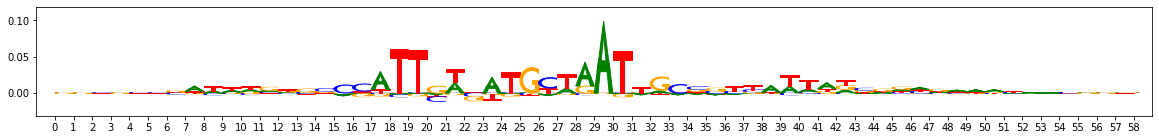

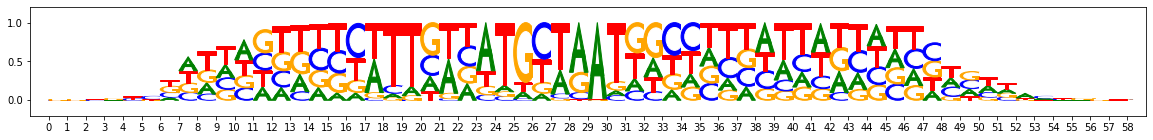

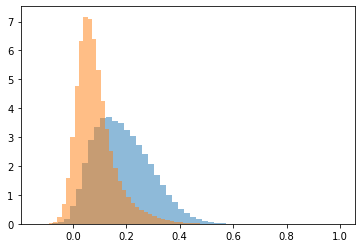

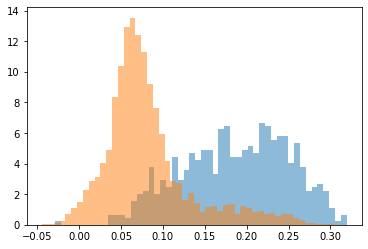

Cluster idx 4 size 278


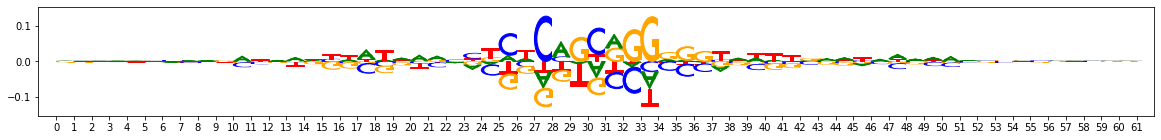

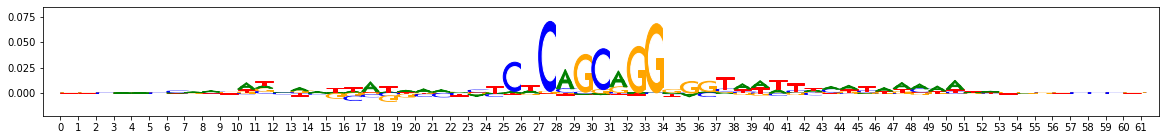

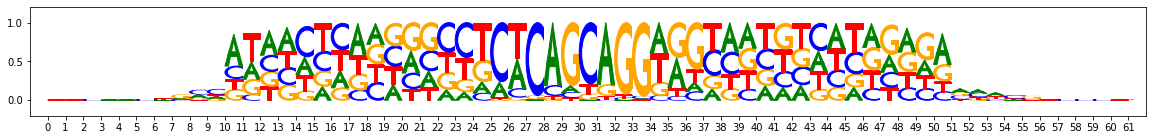

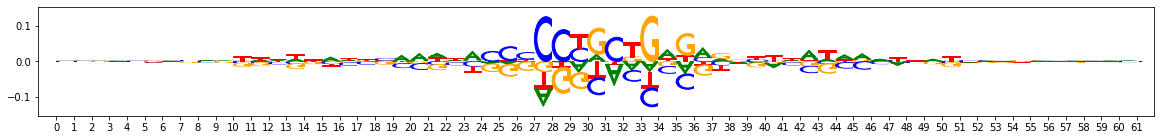

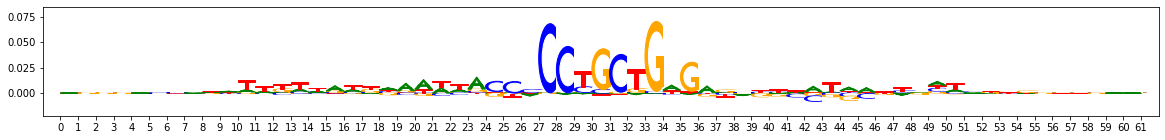

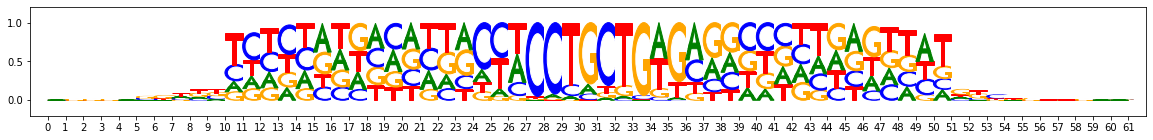

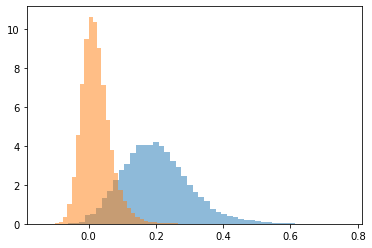

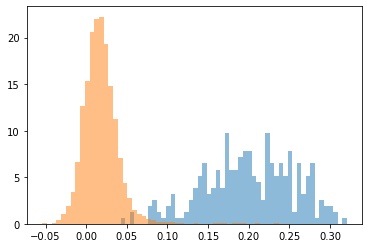

Cluster idx 5 size 212


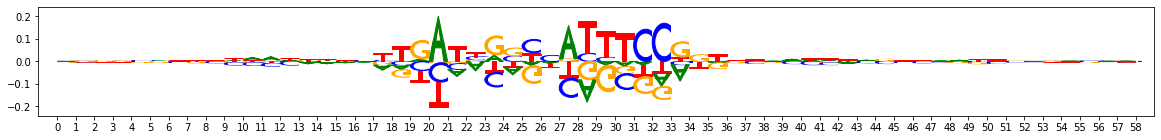

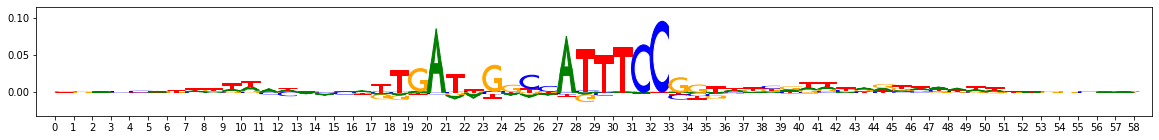

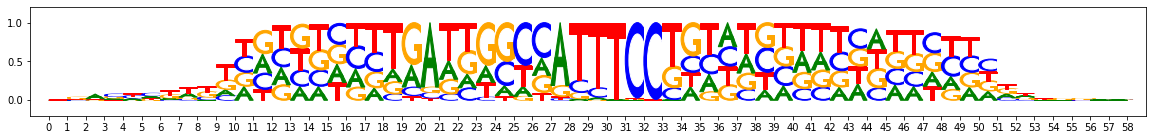

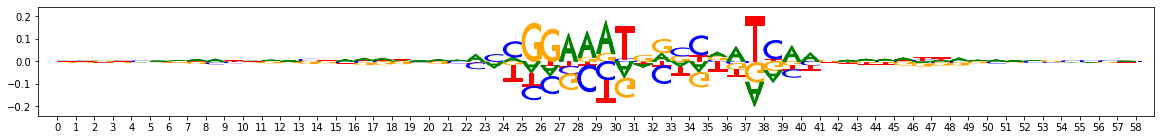

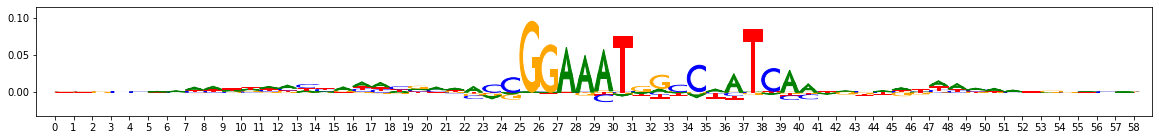

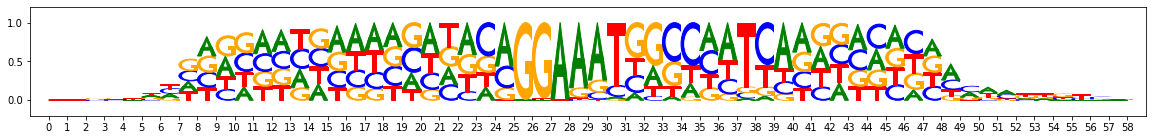

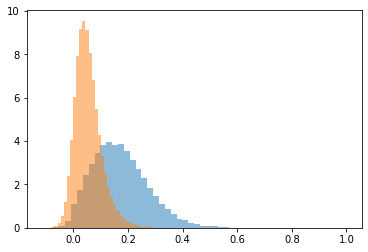

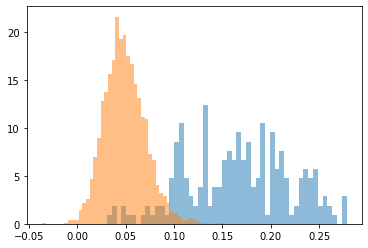

Cluster idx 6 size 174


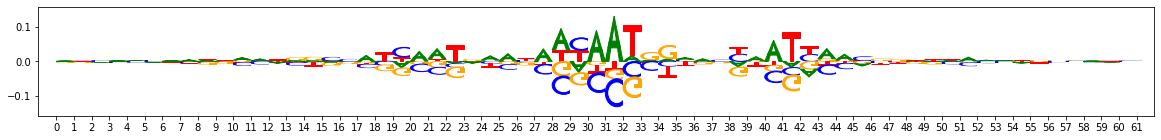

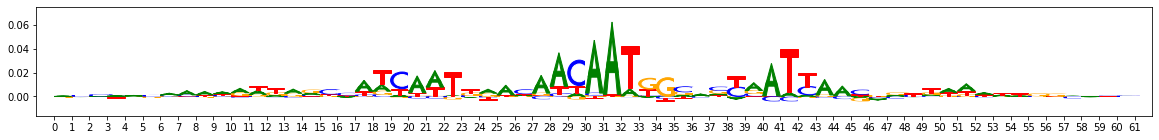

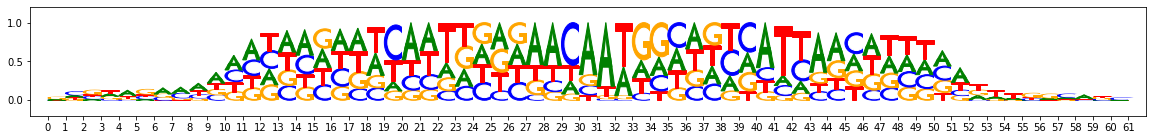

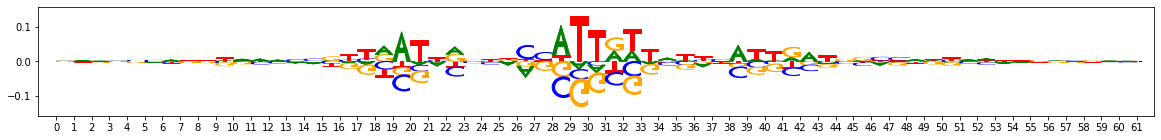

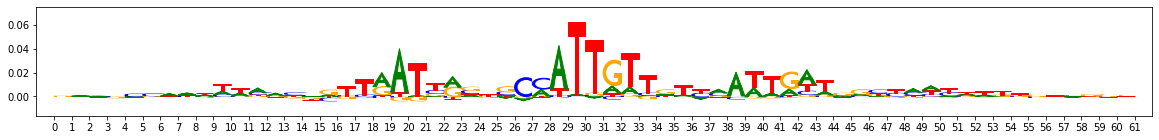

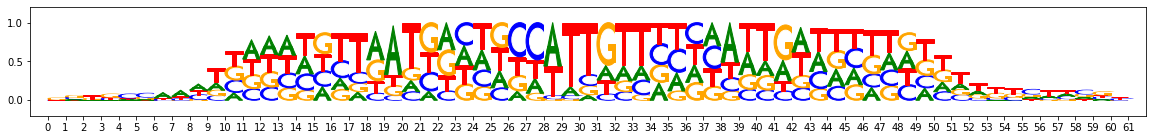

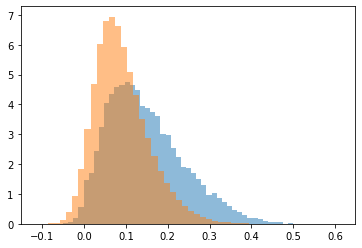

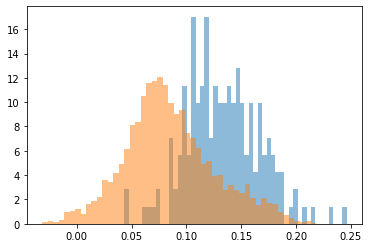

Cluster idx 7 size 94


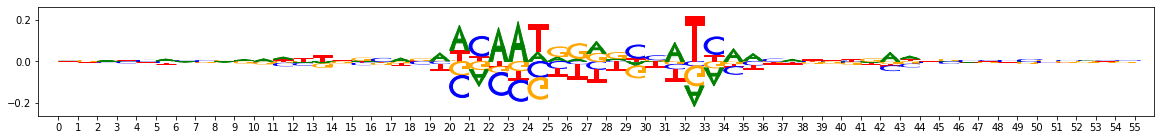

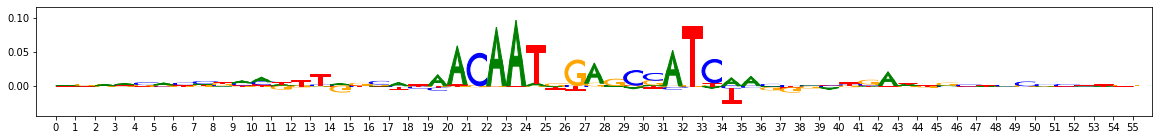

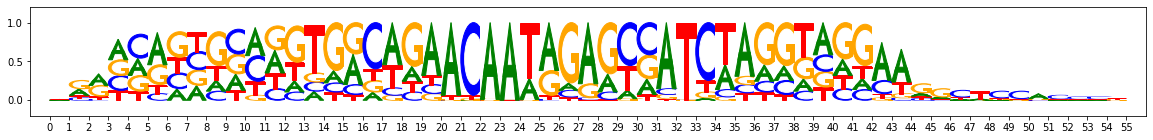

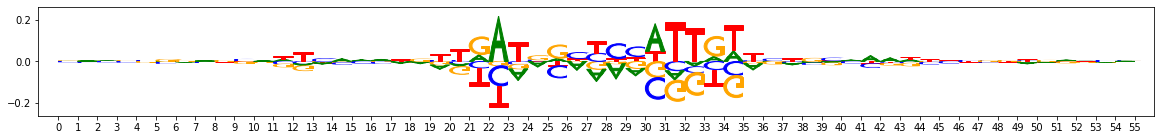

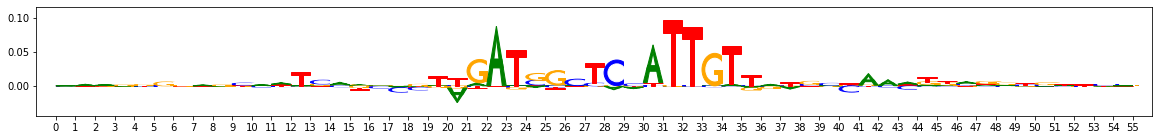

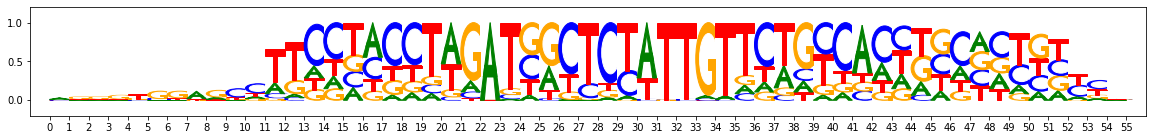

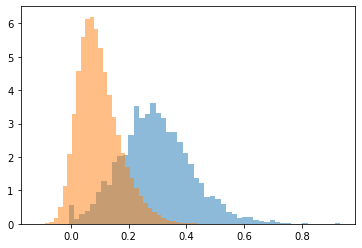

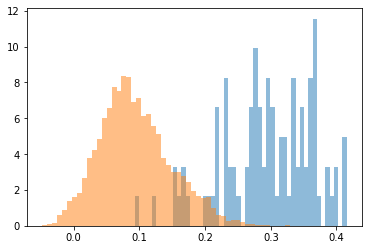

Cluster idx 8 size 53


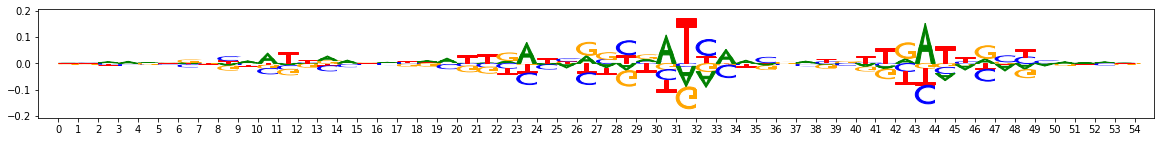

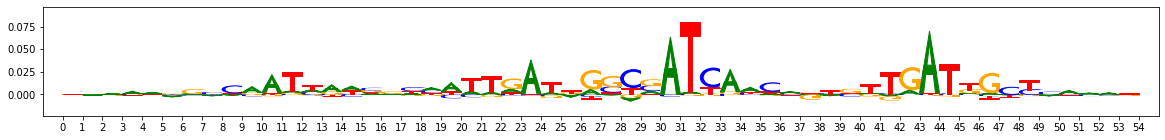

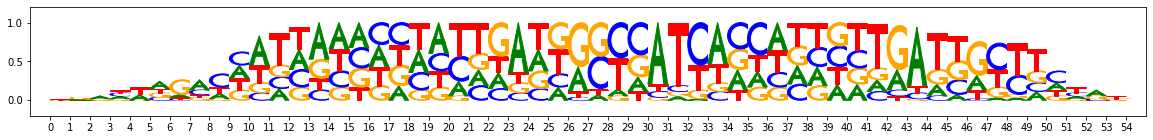

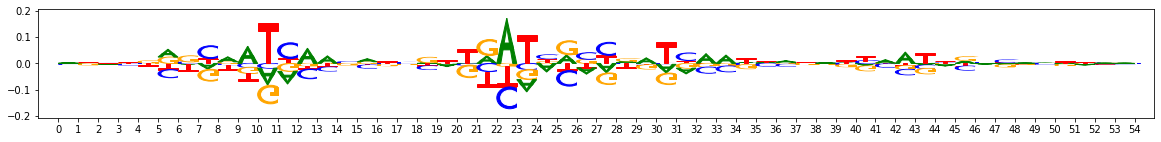

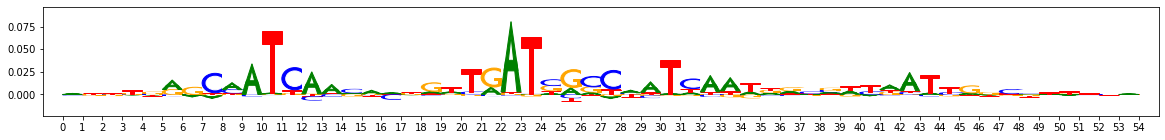

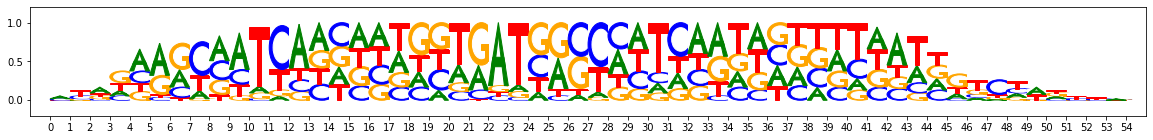

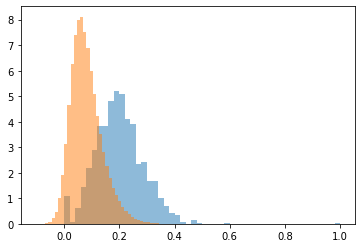

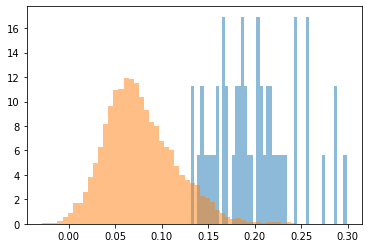

Cluster idx 9 size 31


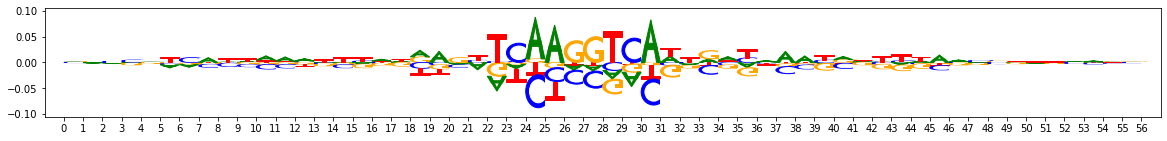

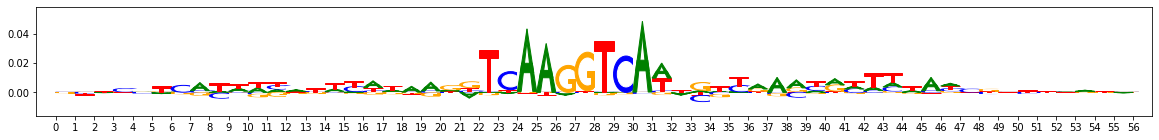

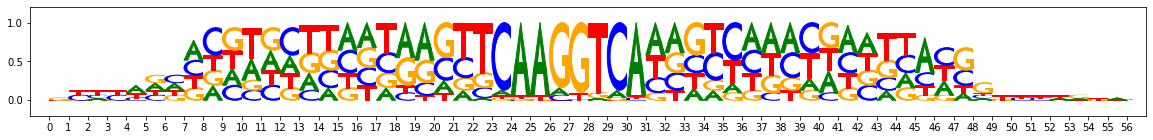

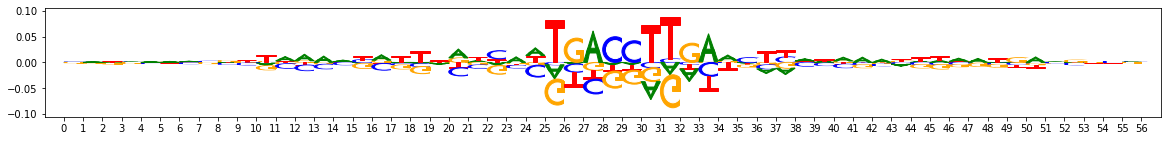

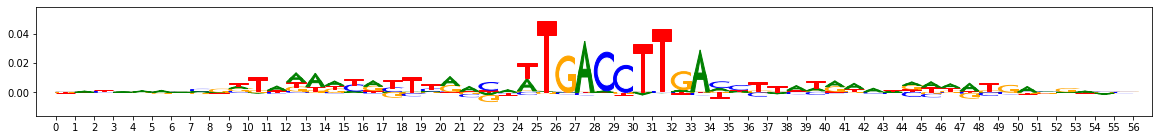

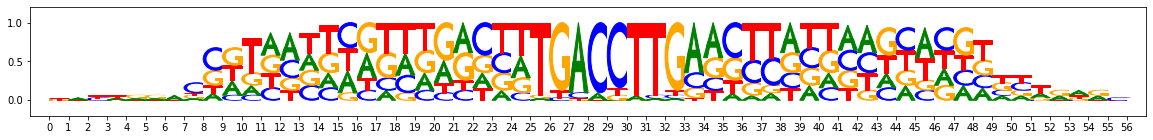

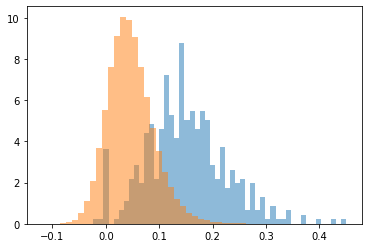

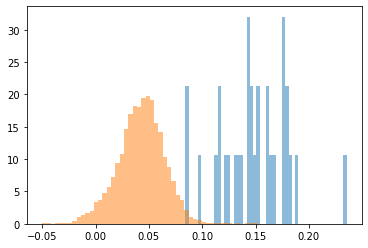

Cluster idx 10 size 24


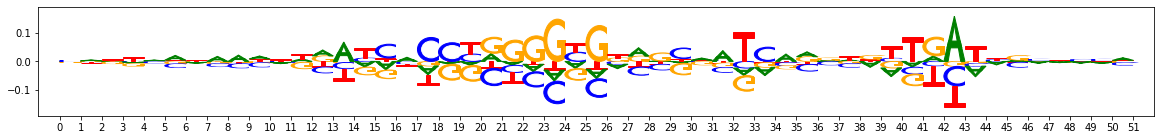

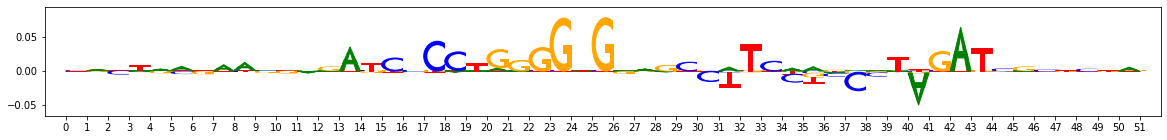

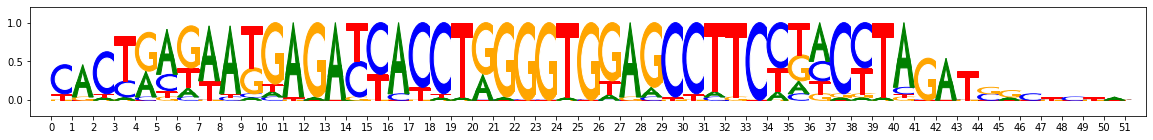

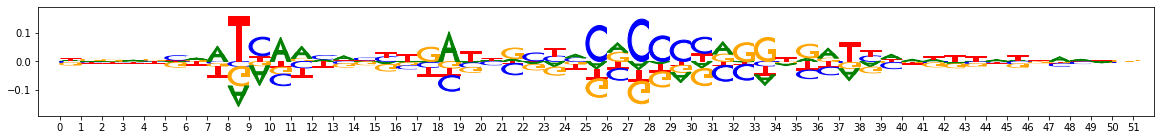

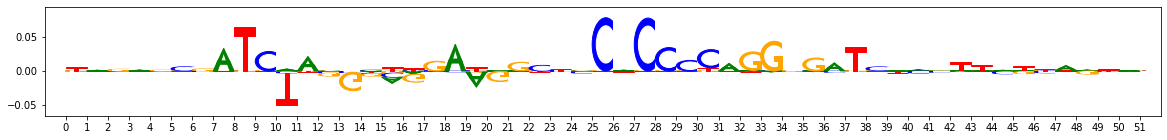

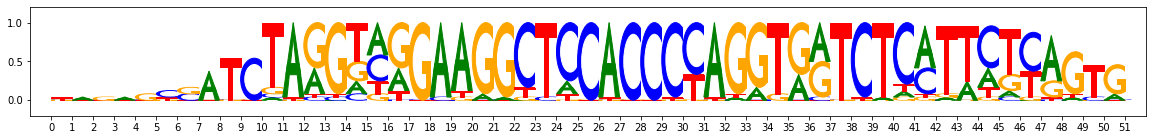

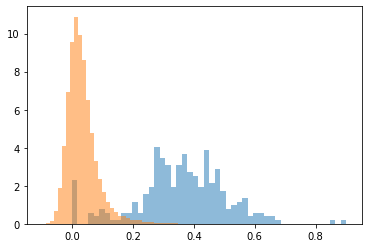

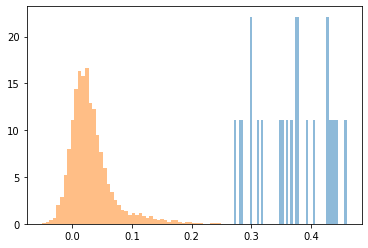

Cluster idx 11 size 19
Cluster idx 12 size 19
Cluster idx 13 size 19
Cluster idx 14 size 18
Cluster idx 15 size 17
Cluster idx 16 size 13
Cluster idx 17 size 12
Cluster idx 18 size 10
Cluster idx 19 size 9
Cluster idx 20 size 9
Cluster idx 21 size 9
Cluster idx 22 size 6
Cluster idx 23 size 6
Cluster idx 24 size 5
Cluster idx 25 size 5
Cluster idx 26 size 5
Cluster idx 27 size 5
Cluster idx 28 size 4
Cluster idx 29 size 3
Cluster idx 30 size 3
Cluster idx 31 size 2
Cluster idx 32 size 2
Cluster idx 33 size 2
Cluster idx 34 size 2
Cluster idx 35 size 2
Cluster idx 36 size 2
Cluster idx 37 size 2
Cluster idx 38 size 2
Cluster idx 39 size 1
Cluster idx 40 size 1
Cluster idx 41 size 1
Cluster idx 42 size 1
Cluster idx 43 size 1
Cluster idx 44 size 1
Cluster idx 45 size 1
Cluster idx 46 size 1
Cluster idx 47 size 1
Cluster idx 48 size 1
Cluster idx 49 size 1
Cluster idx 50 size 1
Cluster idx 51 size 1
Cluster idx 52 size 1
Cluster idx 53 size 1
Cluster idx 54 size 1
Cluster idx 55 size 1
Cl

In [75]:
reload(modisco.core)

seqletimps = np.array([np.sum(x["contrib_scores"].corefwd) for x in seqlets_subsample])

min_cluster_support = 20

print("Numbed of clusters:",np.max(the_clustering)+1)

for idx in range(max(the_clustering)+1):
    in_cluster_mask = idx==the_clustering
    num_in_cluster = np.sum(in_cluster_mask)
    print("Cluster idx",idx,"size",num_in_cluster)
    if (num_in_cluster > min_cluster_support):
        #find an anchor for the cluster as the one with the minimum total distance to all the others
        #ok this doesn't work that well
        #anchor = np.argmin(np.sum(distmat[:,in_cluster_mask],axis=-1)+((in_cluster_mask==False)*np.inf))
        anchor = np.argmax(seqletimps*in_cluster_mask) #highest imp for anchor - this works better
        distsortinfo = np.argsort(distmat[in_cluster_mask, anchor])
        isfwdinfo = isfwdmat[in_cluster_mask,anchor][distsortinfo]
        offsetsinfo = offsets[in_cluster_mask,anchor][distsortinfo]
        seqlets_in_cluster_allfwd_unsorted = [seqlet for seqlet,incluster in zip(seqlets_subsample, in_cluster_mask) if incluster]
        seqlets_in_cluster_allfwd = [seqlets_in_cluster_allfwd_unsorted[i] for i in distsortinfo]
        oriented_seqlets_in_cluster = [(seqlet if isfwd==True else seqlet.get_revcomp())
                                       for (seqlet, isfwd) in zip(seqlets_in_cluster_allfwd, isfwdinfo)]
        #for aseqlet in oriented_seqlets_in_cluster[:3]:
        #    viz_sequence.plot_weights(aseqlet["contrib_scores"].corefwd)
        aggregated_seqlet = modisco.core.AggregatedSeqlet(seqlets=oriented_seqlets_in_cluster[:100],
                                                          offsets=offsetsinfo[:100])
        #viz_sequence.plot_weights(aggregated_seqlet["hypcontrib_scores"].fwd)
        viz_sequence.plot_weights(aggregated_seqlet["hypcontrib_scores"].fwd
                                  - np.mean(aggregated_seqlet["hypcontrib_scores"].fwd, axis=-1)[:,None])
        viz_sequence.plot_weights(aggregated_seqlet["contrib_scores"].fwd)
        viz_sequence.plot_weights(aggregated_seqlet["onehot"].fwd)
        #viz_sequence.plot_weights(aggregated_seqlet["hypcontrib_scores"].rev)
        viz_sequence.plot_weights(aggregated_seqlet["hypcontrib_scores"].rev
                                  - np.mean(aggregated_seqlet["hypcontrib_scores"].rev, axis=-1)[:,None])
        viz_sequence.plot_weights(aggregated_seqlet["contrib_scores"].rev)
        viz_sequence.plot_weights(aggregated_seqlet["onehot"].rev)
        #plot the distribution of pairwise dissimilarities within the cluster
        zerodiagaffmat = affmat*(1-np.eye(affmat.shape[0]))
        plt.hist(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask].ravel(), bins=50, density=True, alpha=0.5)
        plt.hist(zerodiagaffmat[in_cluster_mask==False][:,in_cluster_mask].ravel(), bins=50, density=True, alpha=0.5)
        plt.show()
        plt.hist(np.median(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask],axis=-1), bins=50, density=True, alpha=0.5)
        #plt.hist(np.median(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask==False],axis=-1), bins=50, density=True, alpha=0.5)
        plt.hist(np.median(zerodiagaffmat[in_cluster_mask==False][:,in_cluster_mask],axis=-1), bins=50, density=True, alpha=0.5)
        plt.show()
        #plt.hist(np.median(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask],axis=-1)
        #         - np.median(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask==False],axis=-1), bins=50, density=True, alpha=0.5)
        #plt.show()
        #plt.hist(np.max(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask],axis=-1), bins=50, density=True, alpha=0.5)
        #plt.hist(np.max(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask==False],axis=-1), bins=50, density=True, alpha=0.5)
        #plt.show()
        #plt.hist(np.max(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask],axis=-1)
        #         - np.max(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask==False],axis=-1), bins=50, density=True, alpha=0.5)
        #plt.show()

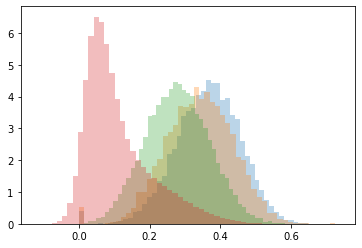

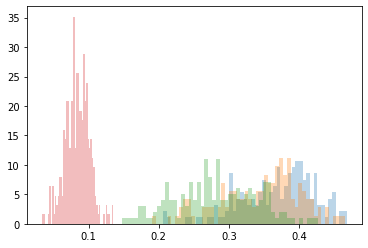

4127


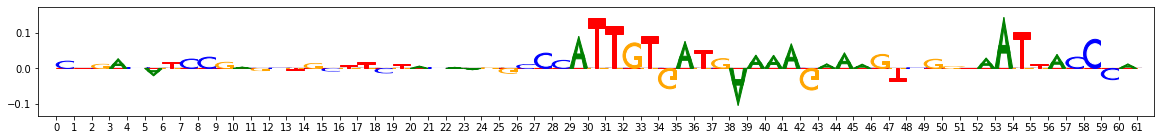

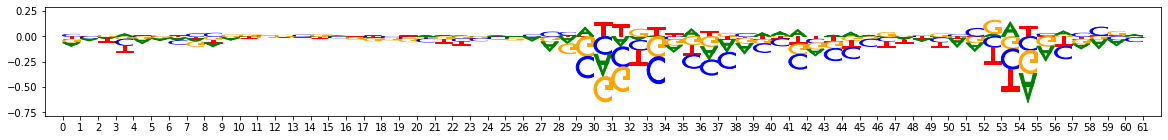

2727


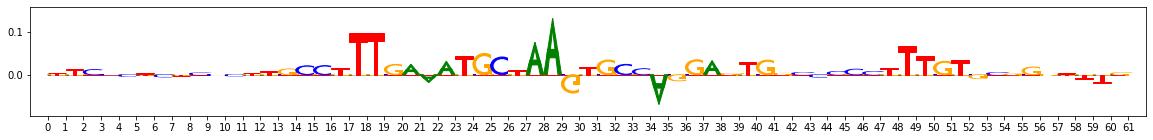

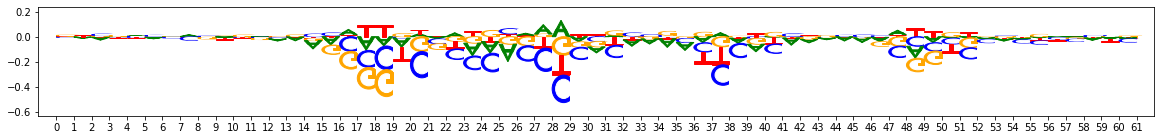

In [34]:
#compare clusters
from modisco.visualization import viz_sequence
cluster1 = 0
cluster2 = 2
incluster1mask = cluster1==the_clustering
incluster2mask = cluster2==the_clustering
zerodiagaffmat = affmat*(1-np.eye(affmat.shape[0]))

cluster1_within = plt.hist(zerodiagaffmat[incluster1mask][:,incluster1mask].ravel(),
                           bins=50, density=True, alpha=0.3)
cluster2_within = plt.hist(zerodiagaffmat[incluster2mask][:,incluster2mask].ravel(),
                           bins=50, density=True, alpha=0.3)
cluster12_between = plt.hist(zerodiagaffmat[incluster1mask][:,incluster2mask].ravel(),
                             bins=50, density=True, alpha=0.3)
cluster12_allelse = plt.hist(zerodiagaffmat[(incluster1mask+incluster2mask > 0)][:,(incluster1mask+incluster2mask)==0].ravel(),
                             bins=50, density=True, alpha=0.3)
plt.show()

cluster1_within = plt.hist(np.median(zerodiagaffmat[incluster1mask][:,incluster1mask],axis=-1),
                           bins=50, density=True, alpha=0.3)
cluster2_within = plt.hist(np.median(zerodiagaffmat[incluster2mask][:,incluster2mask],axis=-1),
                           bins=50, density=True, alpha=0.3)
cluster12_between = plt.hist(np.median(zerodiagaffmat[incluster1mask][:,incluster2mask],axis=-1),
                             bins=50, density=True, alpha=0.3)
cluster12_allelse = plt.hist(np.median(zerodiagaffmat[(incluster1mask+incluster2mask > 0)][:,(incluster1mask+incluster2mask)==0],axis=-1),
                             bins=50, density=True, alpha=0.3)
plt.show()

#find an example with very high within-cluster similarity but high dissim to the other cluster
cluster1typical = np.argmax(np.median(zerodiagaffmat[:,incluster1mask],axis=-1) - np.median(zerodiagaffmat[:,incluster2mask],axis=-1))
print(cluster1typical)
viz_sequence.plot_weights(seqlets_subsample[cluster1typical]["contrib_scores"].get_core_with_flank(left=10, right=10, is_revcomp=False))
viz_sequence.plot_weights(seqlets_subsample[cluster1typical]["hypcontrib_scores"].get_core_with_flank(left=10, right=10, is_revcomp=False))

#find an example with very high within-cluster similarity but high dissim to the other cluster
cluster2typical = np.argmax(np.median(zerodiagaffmat[:,incluster2mask],axis=-1) - np.median(zerodiagaffmat[:,incluster1mask],axis=-1))
print(cluster2typical)
viz_sequence.plot_weights(seqlets_subsample[cluster2typical]["contrib_scores"].get_core_with_flank(left=10, right=10, is_revcomp=False))
viz_sequence.plot_weights(seqlets_subsample[cluster2typical]["hypcontrib_scores"].get_core_with_flank(left=10, right=10, is_revcomp=False))